In [10]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np



In [11]:
# Dataset paths
train_dir = r'C:\Users\Yashuu\Downloads\WFD(MAIN)\Classification\train'
valid_dir = r'C:\Users\Yashuu\Downloads\WFD(MAIN)\Classification\valid'
test_dir = r'C:\Users\Yashuu\Downloads\WFD(MAIN)\Classification\test'



In [12]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=2, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=2, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=2, class_mode='binary', shuffle=False)



Found 1140 images belonging to 2 classes.
Found 380 images belonging to 2 classes.
Found 380 images belonging to 2 classes.


In [13]:
# Callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, verbose=1, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg16_model.h5', monitor='val_loss', save_best_only=True, verbose=1)



In [14]:
# Load full VGG16 model (not reducing layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



In [15]:
# Unfreeze all layers (train the full model)
for layer in base_model.layers:
    layer.trainable = True  



In [16]:
# Define the full VGG16-based model
full_vgg16_model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification (fire/no fire)
])



In [17]:
# Compile model
full_vgg16_model.compile(optimizer=Adam(learning_rate=0.00003), loss='binary_crossentropy', metrics=['accuracy'])



In [18]:
# Train model
history = full_vgg16_model.fit(train_generator, validation_data=valid_generator, epochs=5, callbacks=[lr_reduce, early_stop, checkpoint])



Epoch 1/5
570/570 [==============================] - ETA: 0s - loss: 0.5671 - accuracy: 0.7026
Epoch 1: val_loss improved from inf to 1.41536, saving model to best_vgg16_model.h5
570/570 [==============================] - 920s 2s/step - loss: 0.5671 - accuracy: 0.7026 - val_loss: 1.4154 - val_accuracy: 0.5263 - lr: 3.0000e-05
Epoch 2/5
570/570 [==============================] - ETA: 0s - loss: 0.5425 - accuracy: 0.7289
Epoch 2: val_loss did not improve from 1.41536
570/570 [==============================] - 984s 2s/step - loss: 0.5425 - accuracy: 0.7289 - val_loss: 8.3781 - val_accuracy: 0.4737 - lr: 3.0000e-05
Epoch 3/5
570/570 [==============================] - ETA: 0s - loss: 0.5907 - accuracy: 0.6974
Epoch 3: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.

Epoch 3: val_loss did not improve from 1.41536
570/570 [==============================] - 944s 2s/step - loss: 0.5907 - accuracy: 0.6974 - val_loss: 7.4917 - val_accuracy: 0.5263 - lr: 3.0000e-05
Epoch 4/5
570

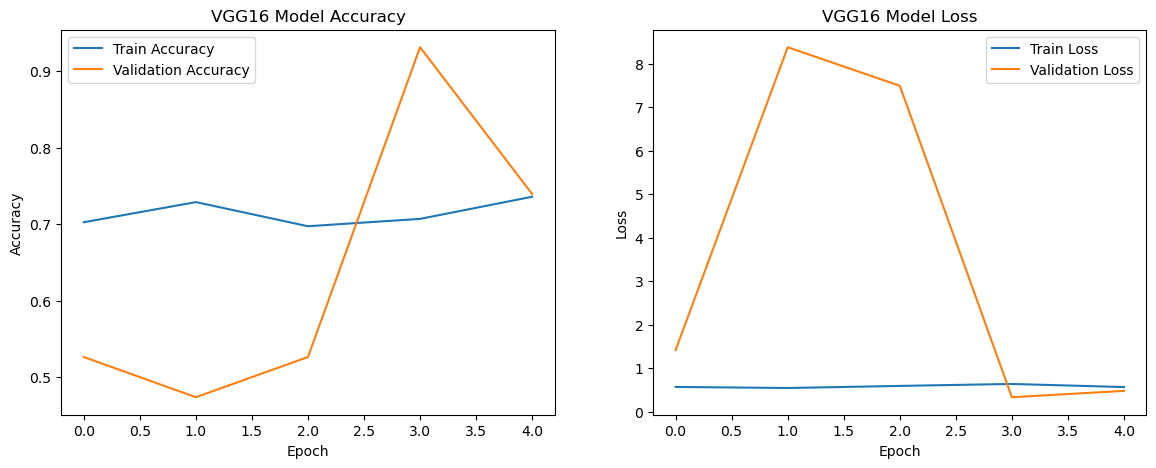

In [19]:
# Plot Accuracy & Loss Curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [20]:

# Evaluate model on test data
test_loss, test_acc = full_vgg16_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')



190/190 [==============================] - 75s 395ms/step - loss: 0.4732 - accuracy: 0.7447
Test Accuracy: 0.7447


In [21]:
# Classification reports
y_true = test_generator.classes
y_pred_full = (full_vgg16_model.predict(test_generator) > 0.7).astype("int32").flatten()


190/190 [==============================] - 80s 403ms/step


In [22]:
from sklearn.metrics import precision_recall_curve, auc

# Get prediction probabilities (needed for PR curve)
y_prob = full_vgg16_model.predict(test_generator).ravel()  # .ravel() to flatten it to 1D array

# Compute Precision-Recall values
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

# Compute AUC for PR Curve
pr_auc = auc(recall, precision)



190/190 [==============================] - 76s 401ms/step


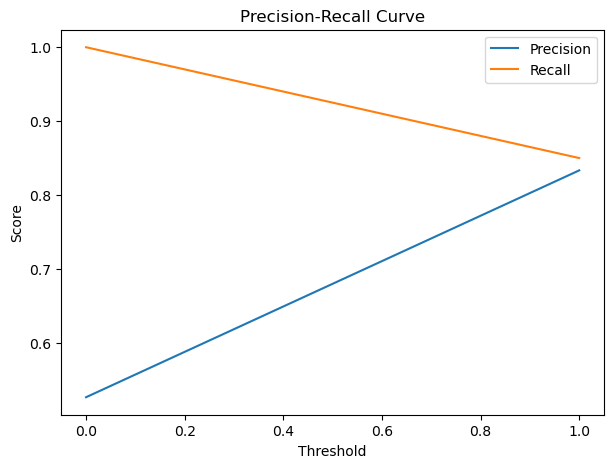

In [23]:
# Precision-Recall curve
from sklearn.metrics import precision_recall_curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_pred_full)

plt.figure(figsize=(7, 5))
plt.plot(thresholds, precision_vals[:-1], label='Precision')
plt.plot(thresholds, recall_vals[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [24]:
# Optional - Print precision, recall, F1-score at your chosen threshold (e.g., 0.6)
from sklearn.metrics import precision_recall_fscore_support

y_pred_full = (y_prob > 0.6).astype(int)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_full, average='binary')
print(f"Threshold 0.6 - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")


Threshold 0.6 - Precision: 0.7551, Recall: 0.9250, F1-Score: 0.8315


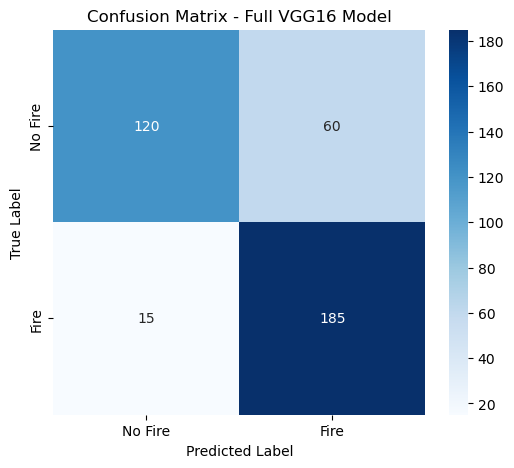

In [25]:
# Confusion Matrix
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_full)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Full VGG16 Model")
plt.show()
